参考链接：
https://productds.com/

https://github.com/Alsukhon/Spanish-Translation/blob/master/AB%20testing%20-%20Spanish%20translation.ipynb

《a collection of data science take home challenge》一书

https://github.com/JifuZhao/DS-Take-Home/blob/master/02.%20Spanish%20Translation%20AB%20Test.ipynb

## 项目一：西班牙语翻译 A / B 测试项目

### 背景：
    某网站一位数据科学家注意到，西班牙用户的转换率比其他西班牙语国家都要高。经调查，推测原因可能是翻译。所有西班牙语国家的网站译本均与西班牙人写的相同。他们同意尝试进行测试，每个国家/地区的翻译要由当地人撰写。也就是说，阿根廷用户会看到由阿根廷人撰写的翻译，墨西哥用户会由墨西哥人撰写，等等。显然，对于西班牙用户而言，一切都不会改变。但是，在运行测试之后，他们真的很惊讶，因为测试是负面的。即，非本地化翻译似乎做得更好！

### 目的：
    探寻这个新版本效果反而不好的原因。（是真的不好还是存在辛普森悖论？）
    对于每个相关细分市场，测控用户的相对比例是相似的，即其实我们需要ABtest进行统计测试之前，检查测试和控制分布是否相似——随机化


In [1]:
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
#read from google drive
test = pd.read_csv("C:/Users/1/data2/practice/AB/test_table.csv")
user=  pd.read_csv("C:/Users/1/data2/practice/AB/user_table.csv")

In [2]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [4]:
print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('User ID:\t', len(user['user_id'].unique()), '\t', len(user['user_id'].unique()) == len(user))

Test ID:	 453321 	 True
User ID:	 452867 	 True


In [5]:
# Merge two tables
data = pd.merge(left=test, right=user, how='inner', on='user_id')
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [7]:
#查看缺失值情况
def missing_values_table(df):
    mis_val = df.isnull().sum() # 总缺失值
    mis_val_percent = 100 * df.isnull().sum() / len(df) # 缺失值比例
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1) # 缺失值制成表格
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing Values',
                                                               1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values',ascending=False).round(1)
    # 缺失值比例列由大到小排序
    
    print('Your selected dataframe has {} columns.\nThere are {} columns that have missing values.'.format(df.shape[1], mis_val_table_ren_columns.shape[0]))
    # 打印缺失值信息
    
    return mis_val_table_ren_columns

print('Train columns with null values:\n',missing_values_table(data))

Your selected dataframe has 12 columns.
There are 1 columns that have missing values.
Train columns with null values:
              Missing Values  % of Total Values
ads_channel          271174               59.9


In [8]:
#不同国家的转化率情况(看看西班牙的转化是否比其他国家好的多)
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean().reset_index()  #先检查老版本
groupby_country = groupby_country.sort_values('conversion', ascending=False)

groupby_country

,country,conversion
14,Spain,0.079719
6,El Salvador,0.053554
10,Nicaragua,0.052647
4,Costa Rica,0.052256
3,Colombia,0.052089
8,Honduras,0.050906
7,Guatemala,0.050643
16,Venezuela,0.050344
13,Peru,0.049914
9,Mexico,0.049495


In [9]:
# A/B test
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

print(test_val.mean(), '\t', cont_val.mean())

0.043411161678422794 	 0.04829179055749524


In [10]:
from scipy.stats import ttest_ind
print(ttest_ind(test_val, cont_val, equal_var=False))

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)


排除了西班牙外，我们发现，测试用户转化率是43%，相比于保持原版本用户，其转化率跌了5%，似乎表明来看，效果不是很好呢，本地化翻译似乎更糟

A / B 测试结果怪异的最可能原因是：
我们没有收集到足够的数据。
实验中引入了一些偏见，因此测试/控制人员并不是真正随机的。

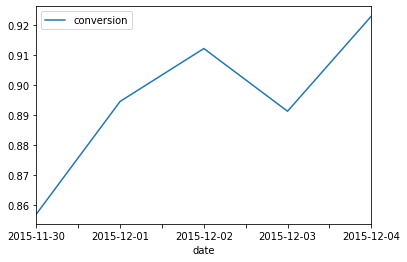

In [12]:
#查看一下测试集和数据集的相对效率
from matplotlib import pyplot as plt
data111=data[data['country'] != 'Spain']
data1=data111[data111['test'] == 0][['conversion', 'date']].groupby('date').mean()
data2=data111[data111['test'] == 1][['conversion', 'date']].groupby('date').mean()
(data2/data1).plot()

 从情节中，我们注意到以下几点：
1. 测试一直比对照差，而且几天之间的变化相对较小。那可能意味着我们确实有足够的数据，但是实验设置中存在一些偏差。
2. 附带说明，我们只运行了 5 天。我们应该始终进行至少 1 个完整的一周的测试以捕获每周的模式，而2周会更好。可能由于某种原因，某些用户群体更有可能最终处于测试或控制状态，该用户群体的转化率明显高于/低于转化率，这影响了总体结果。

In [13]:
##检测AB测试是否随机化
#let's group by source and estimate relative frequencies
data_grouped_source = data111.groupby("source")["test"].agg({
                                         "frequency_test_0": lambda x: len(x[x==0]), 
                                         "frequency_test_1": lambda x: len(x[x==1])})

#get relative frequencies
print(data_grouped_source/data_grouped_source.sum())


        frequency_test_0  frequency_test_1
source                                    
Ads             0.401228          0.400641
Direct          0.200949          0.199500
SEO             0.397823          0.399858


C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


可以看到，不同段的源相对频率是相同的。也就是说，在测试和控制方面，来自Ads，Direct和SEO的用户比例基本相同。我们可能会像这样继续检查所有变量。但这将非常耗时，所以我们打算采取方法是：利用机器学习（决策树）帮助我们判断，检查两个用户分布是否相同（在我们检查组的转化率之前！！）
 
使用变量测试作为我们的标签。尝试建立一个模型，该模型设法将测试值为0的用户与测试值为1的用户区分开。如果随机化工作良好，则这将是不可能的，因为两组完全相同。如果所有变量的相对频率与源的相同，则没有模型能够将test == 1与test == 0分开。如果随机化效果不佳，则模型将设法使用给定变量来将两组分开。作为模型，选择一个决策树。这将使我们清楚地看到哪个变量（如果有）用于拆分，那就是随机化失败的地方！！！

PS：安装graphviz不需要那么麻烦！！！！！直接在cmd中输入：conda install python-graphviz

In [14]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  

#drop user_id, not needed
data111 = data111.drop(['user_id'], axis=1)
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pd.get_dummies(data111)
#model features, test is the label and conversion is not needed here
train_cols = data_dummy.drop(['test', 'conversion'], axis=1)

In [16]:
tree=DecisionTreeClassifier(
    #change weights. Our data set is now perfectly balanced. It makes easier to look at tree output
    class_weight="balanced",
    #only split if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )
tree.fit(train_cols,data_dummy['test'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s.view()

'tree_test.dot.pdf'

## 输出的是pdf 这里我把它上传到这里了~ 

![Image of image](https://raw.githubusercontent.com/haki-777/pictures/master/image.png)

因此我们可以看到测试和控制不一样！来自阿根廷和乌拉圭的用户比受测的用户更有可能受到测试。当country_Argentina为1时，该树将显示处于控制状态的用户约为23％，处于测试状态的用户为77％而不是50/50。对于乌拉圭，比例甚至更高：对照为11％，测试为89％！

In [17]:
#手动检查
print(data_dummy.groupby("test")[["country_Argentina", "country_Uruguay"]].mean())

      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


我们的树是对的！在测试中，有17％的用户来自阿根廷，但在控制方面，只有5％的用户来自阿根廷。乌拉圭更加极端：测试来自乌拉圭的用户占1.7％，而对照组仅占乌拉圭用户的0.2％。
 

这是一个大问题，因为这意味着我们不再将A / B测试中的差异很可能取决于两组之间的用户不同的事实。(传说中的辛普森悖论哈哈哈哈！找到破功方法了！)
 
让我们在实践中检查一下：

In [18]:
from scipy import stats
  
#this is the test results using the orginal dataset
original_data = stats.ttest_ind(data_dummy.loc[data['test'] == 1]['conversion'], 
                                data_dummy.loc[data['test'] == 0]['conversion'], 
                                equal_var=False)
  
#this is after removing Argentina and Uruguay
data_no_AR_UR = stats.ttest_ind(data_dummy.loc[(data['test'] == 1) & (data_dummy['country_Argentina'] ==  0) & (data_dummy['country_Uruguay'] ==  0)]['conversion'], 
                                data_dummy.loc[(data['test'] == 0) & (data_dummy['country_Argentina'] ==  0) & (data_dummy['country_Uruguay'] ==  0)]['conversion'], 
                                equal_var=False)
  
print(pd.DataFrame( {"data_type" : ["Full", "Removed_Argentina_Uruguay"], 
                         "p_value" : [original_data.pvalue, data_no_AR_UR.pvalue],
                         "t_statistic" : [original_data.statistic, data_no_AR_UR.statistic]
                         }))

                   data_type       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  Removed_Argentina_Uruguay  7.200849e-01     0.358346


在控制了国家之后，测试显然显得不重要。鉴于目标是提高转换率，这并不是一个巨大的成功，但是至少我们知道，本地化翻译不会使事情变得更糟！

此时，有两个选择：
        
     1）确认存在错误，请与负责随机化的软件工程师联系，找出问题所在，修复并重新运行测试。 
     2）如果你确实发现一切都很好，但是由于某些原因，这两个国家/地区仅存在问题，则可以调整这两个细分市场的权重，以使相对频率相同，然后重新运行测试
    （★）当你发现错误时，请始终尝试深入研究错误

## 项目二：ABtest样本量及天数确定

### 目标：转化率想从当前的10%上升到11%，需要多少个样本量?多少天?

In [19]:
import statsmodels.stats.api as sms

p1_and_p2 = sms.proportion_effectsize(0.1, 0.11)      ## 这里输入原本的转化率以及我们想提升的转化率
sample_size = sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05)     ##默认的统计功效是0.8，第一类错误是0.05
print("The required sample size per group is ~", round(sample_size))

The required sample size per group is ~ 14744


输出告诉我们，在测试和控制中我们都需要〜15K才能使我们能够检测到指标至少增加+ 1％。
 

我们还可以传递矢量，并查看样本大小如何随着p2的不同值而变化（我们的测试最低转换率以进行更改）。然后，您可以向产品经理证明这一点，以帮助他们选择最佳的最小效果。像这样：


In [20]:
import numpy as np
import matplotlib.pyplot as plt
#Possible p2 values. We choose from 10.5% to 15% with 0.5% increments
possible_p2 = np.arange(.105, .155, .005)
print(possible_p2)

[0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15 ]


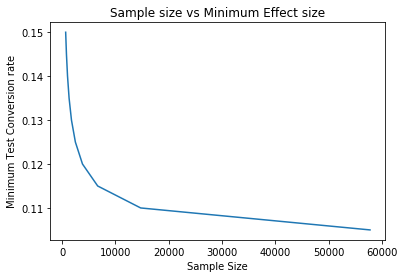

In [21]:
sample_size = []
#now let's estimate sample size for all those values and plot them
for i in possible_p2:
   p1_and_p2 = sms.proportion_effectsize(0.1, i)
   sample_size.append(sms.NormalIndPower().solve_power(p1_and_p2, power=0.8, alpha=0.05))
plt.plot(sample_size, possible_p2)
plt.title("Sample size vs Minimum Effect size")
plt.xlabel("Sample Size")
plt.ylabel("Minimum Test Conversion rate")
plt.show()

【简单来说就是，最低的很小收益要很多数据！】

同时，既然知道测试和控制需要多少人，我们就可以根据每天的流量计算出运行测试需要多少天。
 

广泛使用的方法是：如果我们需要2个多星期才能收集到这么多人，只需将流量按50/50分配并运行，直到获得所需的样本量即可，否则，请继续运行两周，以便能够可靠地捕获每周模式。但是，请在允许用户在两周内收集足够数据的最小比例的用户上进行测试（★）。
 
例：

    1）假设我们的网站每天有1000名访客。我们发现在测试和控制中都需要约15,000名用户才能检测出至少+ 1％的改善。因此，我们将流量分成50/50进行测试和控制。每天我们将有500个用户处于测试状态，而500个处于控制状态。我们将运行测试1个月，即30 * 500 = 15K
 
    2）假设我们的网站每天有10万访客。通过将测试和控制分成50/50，我们将在1天之内获得所需的所有用户。但这太吵了，星期日与星期一不同。如果我们以50/50的比例运行了两个星期，那么我们收集的数据将远远超出我们的需求。而且效率也不高，毕竟我们可以使用该流量来测试其他东西。所以我们做这样的事情：
 
    3）我们希望两周之内有1.5万人。每天约有1000人。由于我们每天有10万访问者，因此我们有1％的用户将进入测试并查看网站的其他版本。因此，大型公司通常会对1％或更少的用户进行测试

(★所以确定天数逻辑是，先确定样本量，其次明确本网站的每日流量，比如有10W人，那就取每天1%用户也就是1000人进行为期两天的测试。）